# サポートベクターマシン

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [2]:
class SVC(object):
    def __init__(self, kernel):
        self.kernel = kernel

    def build_kernel(self, X):
        if self.kernel == 'linear':
            self.K = X.dot(X.T)
        elif self.kernel == 'rbf':
            n_samples = len(X)
            self.K = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(n_samples):
                    self.K[i, j] = self.rbf(X[i], X[j])

    def rbf(self, u, v):
        sigma = 2
        return np.exp(-0.5 * ((u - v)**2).sum() / sigma**2)

    def fit(self, X, y):
        y = np.where(y == 1.0, 1.0, -1.0)
        self.build_kernel(X)
        alpha = self.solve(y)

        self.index = alpha > 1e-5
        self.support_vectors = X[self.index]
        self.support_vector_labels = y[self.index]
        self.support_vector_alpha = alpha[self.index]

        term2 = self.K[self.index][:, self.index].dot(self.support_vector_alpha * self.support_vector_labels)
        self.b = (self.support_vector_labels - term2).mean()

    def solve(self, y):
        learning_rate = 0.01
        n_iter = 500
        n_samples = len(y)

        H = np.outer(y, y) * self.K
        y2 = (y**2).sum()

        alpha = np.ones(n_samples)
        for _ in range(n_iter):
            grad = 1 - H.dot(alpha)
            alpha += learning_rate * grad
            alpha -= alpha.dot(y) * y / y2
            alpha = np.where(alpha > 0, alpha, 0)
            if alpha.max() > 1e7:
                break
        return alpha

    def predict(self, X):
        return np.sign(self.project(X))

    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            for a, sv_y, sv in zip(self.support_vector_alpha, self.support_vector_labels, self.support_vectors):
                if self.kernel == 'linear':
                    y_predict[i] += a * sv_y * sv.dot(X[i])
                elif self.kernel == 'rbf':
                    y_predict[i] += a * sv_y * self.rbf(X[i], sv)
        return y_predict + self.b

## 線形分離可能な場合

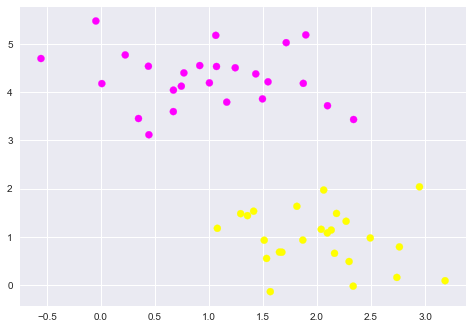

In [3]:
from sklearn.datasets.samples_generator import make_blobs
# データセット生成
X, y = make_blobs(n_samples=50, n_features=2, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

In [4]:
X.shape, y.shape

((50, 2), (50,))

In [5]:
def split_train_test(X, y):
    # 訓練データとテストデータに分ける
    from sklearn.utils import shuffle
    X, y = shuffle(X, y)
    train_ratio = 0.8
    n_train = int(len(y) * train_ratio) 
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [6]:
X_train, y_train, X_test, y_test = split_train_test(X, y)
# SVCクラスのインスタンスを作り、訓練データを学習
svc = SVC('linear')
svc.fit(X_train, y_train)

In [7]:
def score(clf, X_test, y_test):
    # 正解率
    y_test = np.where(y_test == 1, 1, -1)
    y_predict = clf.predict(X_test)
    return (y_predict == y_test).sum() / float(len(y_test))

In [8]:
score(svc, X_test, y_test)

1.0

### 訓練データとテストデータを図示

In [9]:
def plot_svc_decision_function(clf, ax=None):
    # 決定境界とマージンを図示
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.project([[xi, yj]])

    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

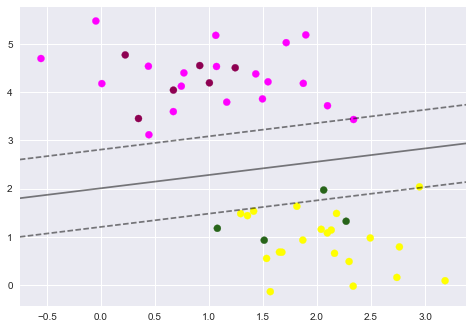

In [10]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='spring')
# テストデータは濃い紫と緑で図示
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='PiYG')
plot_svc_decision_function(svc)

### サポートベクトルを図示

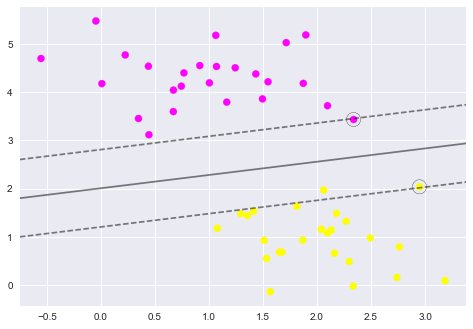

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
# サポートベクトルを枠だけの丸で図示
plt.scatter(svc.support_vectors[:, 0], svc.support_vectors[:, 1],
            s=200, facecolors='none', edgecolors='k')
plot_svc_decision_function(svc)

## 線形分離不可能な場合①

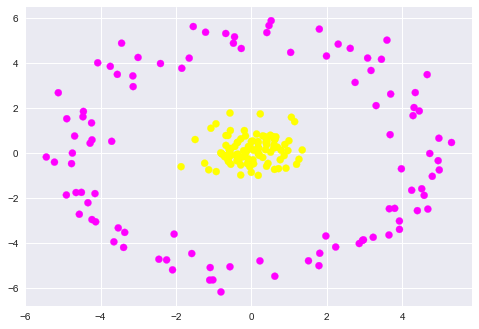

In [12]:
from sklearn.datasets.samples_generator import make_circles
# データセット生成
X, y = make_circles(200, factor=.1, noise=.1)
X *= 5

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

In [13]:
# rbfカーネルを使用
clf = SVC(kernel='rbf')
clf.fit(X, y)

### 決定境界とサポートベクトルを図示

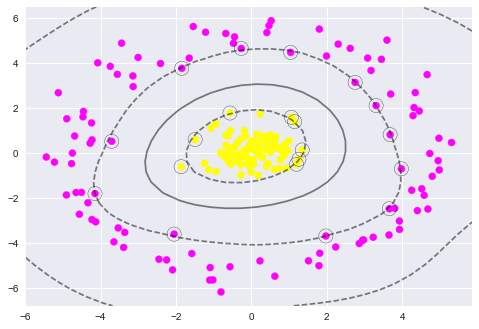

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors[:, 0], clf.support_vectors[:, 1],
            s=200, facecolors='none', edgecolors='k')

## 線形分離不可能な場合②

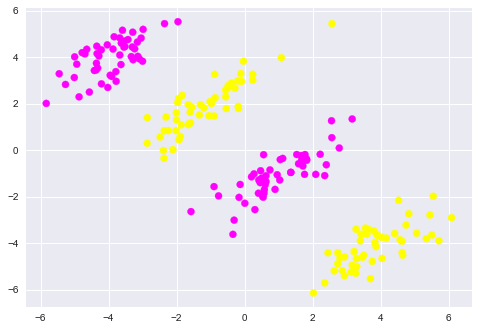

In [15]:
def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))
    return X, y

# データセット生成
X, y = gen_non_lin_separable_data()
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

### 線形カーネルSVMの場合

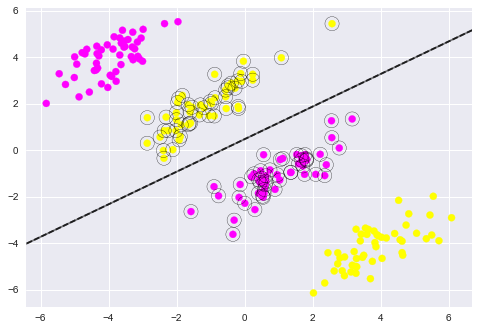

In [16]:
linear_clf = SVC('linear')
linear_clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(linear_clf)
plt.scatter(linear_clf.support_vectors[:, 0], linear_clf.support_vectors[:, 1],
            s=200, facecolors='none', edgecolors='k')

### rbfカーネルの場合

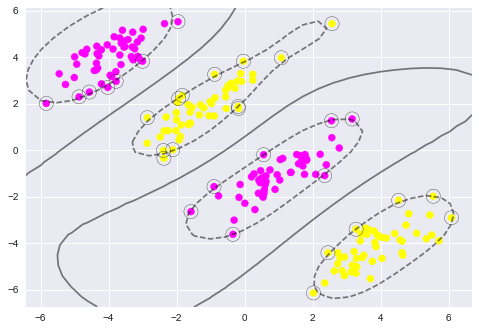

In [17]:
rbf_clf = SVC(kernel='rbf')
rbf_clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
P = plot_svc_decision_function(rbf_clf)
plt.scatter(rbf_clf.support_vectors[:, 0], rbf_clf.support_vectors[:, 1],
            s=200, facecolors='none', edgecolors='k')